In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
from PIL import Image
import random


In [2]:
lr_images_path = '../data/lr_images'
hr_images_path = '../data/hr_images'

In [3]:
lr_filenames = sorted(os.listdir(lr_images_path))[:]
hr_filenames = sorted(os.listdir(hr_images_path))[:]

# Verify that the filenames match
if lr_filenames != hr_filenames:
    raise ValueError("Filenames in lr_images and hr_images do not match!")

In [4]:
lr_images = []
hr_images = []


for img_name in lr_filenames:
    lr_img = Image.open(os.path.join(lr_images_path, img_name))
    hr_img = Image.open(os.path.join(hr_images_path, img_name))
    
    # Convert grayscale images to RGB format
    if lr_img.mode != 'RGB':
        lr_img = lr_img.convert('RGB')
        
    if hr_img.mode != 'RGB':
        hr_img = hr_img.convert('RGB')
    
    lr_img = np.asarray(lr_img)/255.0
    hr_img = np.asarray(hr_img)/255.0
    
    lr_images.append(lr_img)
    hr_images.append(hr_img)

In [5]:
lr_images_array = np.stack(lr_images)
hr_images_array = np.stack(hr_images)

print("LR Images Array Shape:", lr_images_array.shape)
print("HR Images Array Shape:", hr_images_array.shape)

LR Images Array Shape: (15129, 64, 64, 3)
HR Images Array Shape: (15129, 128, 128, 3)


In [6]:
# Split the data into training, validation, and test sets
random_seed = 42 

train_lr_images, val_test_lr_images, train_hr_images, val_test_hr_images = train_test_split(
    lr_images_array, hr_images_array, test_size=0.3, random_state=random_seed
)

val_lr_images, test_lr_images, val_hr_images, test_hr_images = train_test_split(
    val_test_lr_images, val_test_hr_images, test_size=0.5, random_state=random_seed
)

In [7]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D(size = 2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


In [8]:
#Generator model
def create_gen(gen_ip, num_res_block):
    
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    
    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [9]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [10]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 16
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)

    d8_5 = Flatten()(d6)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [11]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [12]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [13]:
lr_shape = (lr_images_array.shape[1], lr_images_array.shape[2], lr_images_array.shape[3])
hr_shape = (hr_images_array.shape[1], hr_images_array.shape[2], hr_images_array.shape[3])

In [14]:
lr_images_array.shape

(15129, 64, 64, 3)

In [15]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-09-19 17:54:54.317483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-19 17:54:54.318440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [16]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                           

In [17]:
vgg = build_vgg((128,128,3))
vgg.trainable = False
print(vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [18]:
srgan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
srgan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
srgan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  1453955     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            4267729     ['model[0][0]']            

In [19]:
batch_size = 16  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_images_array.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_images_array[start_idx:end_idx])
    train_lr_batches.append(lr_images_array[start_idx:end_idx])
    

In [20]:
epochs = 20
for e in range(epochs):

    print(f"Epoch {e+1} starting")
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = srgan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    with open('training_logs.txt', 'a+') as log_file:
        log_file.write(f"Epoch: {e+1}, Generative Loss: {g_loss}, Discriminator Loss: {d_loss}")
     

    if (e+1) % 2 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("./generator_ckpts/gen_e_"+ str(e+1) +".h5")

Epoch 1 starting


  0%|          | 0/945 [00:00<?, ?it/s]2023-09-19 17:54:57.094925: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-19 17:54:57.096909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-19 17:54:58.311468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 114ms/step


2023-09-19 17:54:59.076290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-19 17:55:00.479086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
  0%|          | 1/945 [00:09<2:27:09,  9.35s/it]

1/1 [==============================] - 0s 55ms/step


  0%|          | 2/945 [00:12<1:27:09,  5.55s/it]

1/1 [==============================] - 0s 42ms/step


  0%|          | 3/945 [00:15<1:10:39,  4.50s/it]

1/1 [==============================] - 0s 67ms/step


  0%|          | 4/945 [00:17<57:58,  3.70s/it]  

1/1 [==============================] - 0s 35ms/step


  1%|          | 5/945 [00:22<1:02:52,  4.01s/it]

1/1 [==============================] - 0s 37ms/step


  1%|          | 6/945 [00:25<57:29,  3.67s/it]  

1/1 [==============================] - 0s 43ms/step


  1%|          | 7/945 [00:28<51:31,  3.30s/it]

1/1 [==============================] - 0s 55ms/step


  1%|          | 8/945 [00:32<55:48,  3.57s/it]

1/1 [==============================] - 0s 216ms/step


  1%|          | 9/945 [00:36<59:05,  3.79s/it]

1/1 [==============================] - 0s 153ms/step


  1%|          | 10/945 [00:39<57:38,  3.70s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 11/945 [00:42<52:45,  3.39s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 12/945 [00:44<47:32,  3.06s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 13/945 [00:47<43:25,  2.80s/it]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 14/945 [00:50<44:41,  2.88s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 15/945 [00:53<48:30,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 16/945 [00:56<46:25,  3.00s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 17/945 [00:59<43:57,  2.84s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 18/945 [01:02<46:55,  3.04s/it]

1/1 [==============================] - 0s 88ms/step


  2%|▏         | 19/945 [01:05<46:02,  2.98s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 20/945 [01:07<43:35,  2.83s/it]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 21/945 [01:10<42:38,  2.77s/it]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 22/945 [01:13<42:44,  2.78s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 23/945 [01:16<42:49,  2.79s/it]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 24/945 [01:19<44:22,  2.89s/it]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 25/945 [01:22<43:43,  2.85s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 26/945 [01:25<45:27,  2.97s/it]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 27/945 [01:28<46:11,  3.02s/it]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 28/945 [01:32<51:16,  3.35s/it]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 29/945 [01:39<1:05:48,  4.31s/it]

1/1 [==============================] - 0s 73ms/step


  3%|▎         | 30/945 [01:42<1:01:30,  4.03s/it]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 31/945 [01:47<1:04:41,  4.25s/it]

1/1 [==============================] - 0s 70ms/step


  3%|▎         | 32/945 [01:52<1:07:50,  4.46s/it]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 33/945 [01:56<1:07:02,  4.41s/it]

1/1 [==============================] - 0s 76ms/step


  4%|▎         | 34/945 [02:04<1:24:38,  5.58s/it]

1/1 [==============================] - 0s 338ms/step


  4%|▎         | 35/945 [02:17<1:54:48,  7.57s/it]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 36/945 [02:27<2:05:43,  8.30s/it]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 37/945 [02:32<1:54:29,  7.57s/it]

1/1 [==============================] - 0s 97ms/step


  4%|▍         | 38/945 [02:38<1:43:38,  6.86s/it]

1/1 [==============================] - 0s 83ms/step


  4%|▍         | 39/945 [02:44<1:39:57,  6.62s/it]

1/1 [==============================] - 0s 86ms/step


  4%|▍         | 40/945 [02:48<1:28:47,  5.89s/it]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 41/945 [02:53<1:23:30,  5.54s/it]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 42/945 [03:00<1:31:45,  6.10s/it]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 43/945 [03:03<1:19:19,  5.28s/it]

1/1 [==============================] - 0s 77ms/step


  5%|▍         | 44/945 [03:07<1:12:11,  4.81s/it]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 45/945 [03:11<1:07:52,  4.53s/it]

1/1 [==============================] - 0s 52ms/step


  5%|▍         | 46/945 [03:14<1:02:54,  4.20s/it]

1/1 [==============================] - 0s 72ms/step


  5%|▍         | 47/945 [03:18<1:00:37,  4.05s/it]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 48/945 [03:22<58:46,  3.93s/it]  

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 49/945 [03:25<57:07,  3.83s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 50/945 [03:29<56:09,  3.76s/it]

1/1 [==============================] - 0s 53ms/step


  5%|▌         | 51/945 [03:33<55:39,  3.73s/it]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 52/945 [03:36<56:12,  3.78s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 53/945 [03:40<56:14,  3.78s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 54/945 [03:44<56:36,  3.81s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 55/945 [03:48<56:13,  3.79s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 56/945 [03:52<56:06,  3.79s/it]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 57/945 [03:55<56:15,  3.80s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 58/945 [03:59<56:47,  3.84s/it]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 59/945 [04:04<58:32,  3.96s/it]

1/1 [==============================] - 0s 88ms/step


  6%|▋         | 60/945 [04:12<1:16:09,  5.16s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▋         | 61/945 [04:17<1:17:32,  5.26s/it]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 62/945 [04:21<1:09:51,  4.75s/it]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 63/945 [04:28<1:20:12,  5.46s/it]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 64/945 [04:33<1:17:47,  5.30s/it]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 65/945 [04:36<1:08:43,  4.69s/it]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 66/945 [04:41<1:09:55,  4.77s/it]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 67/945 [04:45<1:05:33,  4.48s/it]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 68/945 [04:49<1:02:58,  4.31s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 69/945 [04:52<1:00:36,  4.15s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 70/945 [04:56<58:57,  4.04s/it]  

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 71/945 [05:01<1:02:26,  4.29s/it]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 72/945 [05:07<1:08:44,  4.72s/it]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 73/945 [05:10<59:58,  4.13s/it]  

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 74/945 [05:13<58:32,  4.03s/it]

1/1 [==============================] - 0s 162ms/step


  8%|▊         | 75/945 [05:17<58:46,  4.05s/it]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 76/945 [05:21<57:24,  3.96s/it]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 77/945 [05:25<56:18,  3.89s/it]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 78/945 [05:29<55:09,  3.82s/it]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 79/945 [05:32<54:47,  3.80s/it]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 80/945 [05:36<55:06,  3.82s/it]

1/1 [==============================] - 0s 70ms/step


  9%|▊         | 81/945 [05:40<55:29,  3.85s/it]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 82/945 [05:46<1:05:06,  4.53s/it]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 83/945 [05:55<1:25:25,  5.95s/it]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 84/945 [06:05<1:39:22,  6.93s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 85/945 [06:10<1:33:58,  6.56s/it]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 86/945 [06:13<1:18:42,  5.50s/it]

1/1 [==============================] - 0s 86ms/step


  9%|▉         | 87/945 [06:18<1:13:31,  5.14s/it]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 88/945 [06:21<1:07:16,  4.71s/it]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 89/945 [06:25<1:01:56,  4.34s/it]

1/1 [==============================] - 0s 56ms/step


 10%|▉         | 90/945 [06:29<59:41,  4.19s/it]  

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 91/945 [06:32<57:36,  4.05s/it]

1/1 [==============================] - 0s 84ms/step


 10%|▉         | 91/945 [06:37<1:02:09,  4.37s/it]


KeyboardInterrupt: 

In [25]:
generator = load_model('results/generator_ckpts/gen_e_6.h5')

In [32]:
preds = generator.predict(test_lr_images)

71/71 [==============================] - 75s 1s/step


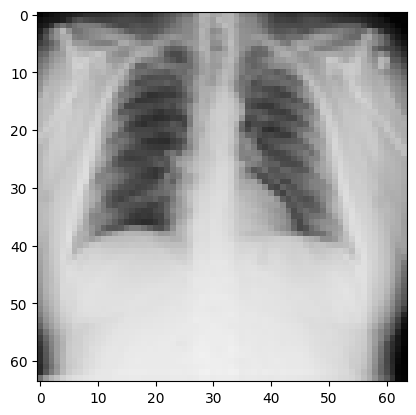

In [50]:
plt.imshow(test_lr_images[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


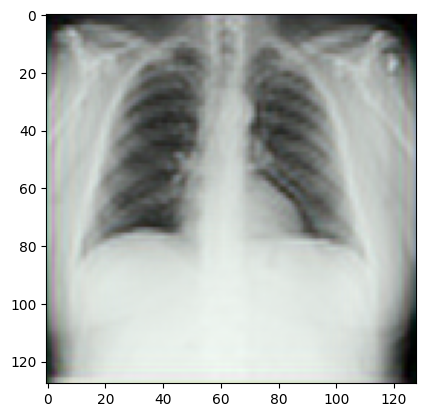

In [51]:
plt.imshow(preds[1])

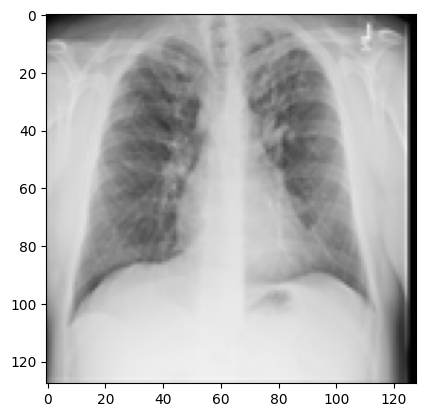

In [52]:
plt.imshow(test_hr_images[0])

In [39]:
import tensorflow as tf

def psnr(y_true, y_pred):
    # Ensure the images have pixel values between 0 and 1
    y_true = tf.image.convert_image_dtype(y_true, tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, tf.float32)

    # Calculate MSE (Mean Squared Error)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Calculate PSNR using the formula: PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
    max_i = 1.0  # Max pixel value (assumed to be 1.0 for normalized images)
    psnr_value = 20 * tf.math.log(max_i) / tf.math.log(10.0) - 10 * tf.math.log(mse) / tf.math.log(10.0)

    return psnr_value


In [44]:
psnr_list = []

for true, pred in zip(test_hr_images, preds):
    psnr_list.append(psnr(true, pred))


In [45]:
np.mean(psnr_list)

30.837954